# **Lab 3: Logistic Regression**

---
NOTE: This is a lab project accompanying the following book [MLF] and it should be used together with the book.

[MLF] *H. Jiang*, "[Machine Learning Fundamentals: A Concise Introduction](http://wiki.eecs.yorku.ca/user/hj/research:mlfbook)", Cambridge University Press, 2021.  ([bibtex](http://www.cse.yorku.ca/~hj/mlf-jiang.bib))

---


The purpose of this lab is to apply a group of closely-related machine learning methods for linear models to pattern classification tasks, including logistic regression, minimum classification error (MCE) and log-linear models. As opposed to linear regression, these methods are particularly designed to solve classification problems. As a result, they normally outperform linear regression in most classification problems. However, these methods do not have a closed-form solution so that we will have to rely on iterative optimization methods to learn them iteratively from training data. In this project, we will give a full implementation for logistic regression and leave MCE and log-linear models as exercises. 
Readers may use the given logistic regression codes as a template to implement the other two methods.  

Prerequisites: N/A

## **I. Logistic Regression**

### **Example 3.1:**

Use logistic regression to build a binary classifier to classify two digits ('3' and '8') in the MNIST data set. Use the mini-batch stochastic gradient descent (SGD) method to learn it from training data, and compare the results with those of linear regression in Problem 2.2.

In [ ]:
#link my Google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install python_mnist

!pip install python_mnist

In [ ]:
#load MINST images

from mnist import MNIST
import numpy as np

mnist_loader = MNIST('/content/drive/My Drive/Colab Notebooks/datasets/MNIST')
train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
train_data = np.array(train_data, dtype='float')/255 # norm to [0,1]
train_label = np.array(train_label, dtype='short')
test_data = np.array(test_data, dtype='float')/255 # norm to [0,1]
test_label = np.array(test_label, dtype='short')

#add small random noise to avoid matrix singularity
train_data += np.random.normal(0,0.0001,train_data.shape) 

print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


In [138]:
# prepare digits '3' and '8' for logisic regression

digit_train_index = np.logical_or(train_label == 3, train_label == 8)
X_train = train_data[digit_train_index]
y_train = train_label[digit_train_index]
digit_test_index = np.logical_or(test_label == 3, test_label == 8)
X_test = test_data[digit_test_index]
y_test = test_label[digit_test_index]

# add a constant column of '1' to accomodate the bias (see the margin note on page 107)
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1), dtype=X_train.dtype)))
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1), dtype=X_test.dtype)))

# converge labels: '3' => -1, '8' => +1
CUTOFF = 5 # any number between '3' and '8'
y_train = np.sign(y_train-CUTOFF)
y_test = np.sign(y_test-CUTOFF)

As shown in Eq.(6.16) on page 115, the objective function in logistic regression is given as:
$$
Q(\mathbf{w}) = -\ln L(\mathbf{w}) = - \frac{1}{N}\sum_{i=1}^N  \ln  l( y_i \mathbf{w}^\intercal \mathbf{x}_i )
$$
and the gradient can be easily computed as in Eq.(6.17):
\begin{eqnarray}
\frac{\partial Q(\mathbf{w})}{\partial \mathbf{w}}
& = & -\frac{1}{N}\sum_{i=1}^N y_i \Big( 1 - l( y_i \mathbf{w}^\intercal \mathbf{x}_i ) \Big) \mathbf{x}_i  \nonumber \\
& = & \frac{1}{N}\sum_{i=1}^N  \Big(y_i \, l( y_i \mathbf{w}^\intercal \mathbf{x}_i) -y_i\Big) \mathbf{x}_i 
\end{eqnarray}
where $l(\cdot)$ denotes the sigmoid function (see Eq.(6.12) on page 114).

Here let us consider how to manipulate the above results to derive a vectorization formula for us to compute the gradients for all feature vectors in a mini-batch. Assume a mini-batch is given as $\mathcal{B} = \big\{ 
  \mathbf{x}_1, \mathbf{x}_2, \cdots, \mathbf{x}_B \big\}$, the average gradient for this mini-batch is computed as:
  $$
   \frac{\partial Q(\mathbf{w}; \mathcal{B} )}{\partial \mathbf{w}}
   = \frac{1}{B} \sum_{i=1}^B  \Big( y_i \, l( y_i \mathbf{w}^\intercal \mathbf{x}_i) - y_i \Big) \mathbf{x}_i
  $$ 

As the way on page 112, we first pack all $\mathbf{x}_i$ in $\mathcal{B}$ row by row as a matrix $\mathbf{X}  \in \mathbb{R}^{B \times d}$, and all $y_i $ as a column vector $\mathbf{y} \in \mathbb{R}^{B \times 1}$, we can verify that the above gradient can be computed equivalently by the following matrix operation:
$$
\frac{\partial Q(\mathbf{w}; \mathcal{B} )}{\partial \mathbf{w}} 
 =  \frac{1}{B} \; \mathbf{X}^\intercal \Big[ \mathbf{y} \odot  l \big(\mathbf{y} \odot ( \mathbf{X} \mathbf{w})\big) - \mathbf{y}  \Big] \;\;\;\;\;\;\; \big(\in \mathbb{R}^{d \times 1}\big)
$$
where $\odot$ denotes element-wise multiplication.

Similarly, if we pack all samples in the training set as $\mathbf{X} \in \mathbb{R}^{N \times d}$ and $\mathbf{y} \in \mathbb{R}^{N \times 1}$ in the same way, we can compute the above loss function $Q(\mathbf{w})$ via vectorization as the mean of all elements in the following vector:
$$
-\ln \Big( l \big(\mathbf{y} \odot ( \mathbf{X} \mathbf{w})\big) \Big) \;\;\;\;\;\;\; \big(\in \mathbb{R}^{N \times 1}\big)
$$

In [139]:
# solve logistic regression using mini-batch gradient descent 
import numpy as np

class Optimizer():
  def __init__(self, lr, annealing_rate, batch_size, max_epochs):
    self.lr = lr
    self.annealing_rate = annealing_rate
    self.batch_size = batch_size
    self.max_epochs = max_epochs

# sigmoid for numpy arrays
def sigmoid(x):
  return 1/(1 + np.exp(-x))

# X[N,d]: training features; y[N]: training targets; 
# X2[N,d]: test features; y2[N]: test targets;  
# op: hyper-parameters for optimzer 
#
# Note: X2 and y2 are not used in training
#       but only for computting the learning curve B
#
def logistic_regression_gd(X, y, X2, y2, op):
  n = X.shape[0]            # number of samples
  w = np.zeros(X.shape[1])  # initialization

  lr = op.lr
  errorsA = np.zeros(op.max_epochs)
  errorsB = np.zeros(op.max_epochs)
  errorsC = np.zeros(op.max_epochs)

  for epoch in range(op.max_epochs):
    indices = np.random.permutation(n)  #randomly shuffle data indices
    for batch_start in range(0, n, op.batch_size):
      X_batch = X[indices[batch_start:batch_start + op.batch_size]]
      y_batch = y[indices[batch_start:batch_start + op.batch_size]]

      # vectorization to compute gradients for a whole mini-batch (see the above formula)
      w_grad = X_batch.T @ (y_batch * sigmoid(y_batch * (X_batch @ w)) - y_batch) / X_batch.shape[0] 

      w -= lr * w_grad 

    # for learning curve C
    errorsC[epoch]  = - np.mean(np.log( sigmoid(y * (X @ w))) )  # logisic regression loss function
                                                                 # see the above formula 
    # for learning curve A
    predict = np.sign(X @ w)
    errorsA[epoch] = np.count_nonzero(np.equal(predict,y))/y.size 

    # for learning curve B
    predict2 = np.sign(X2 @ w)
    errorsB[epoch] = np.count_nonzero(np.equal(predict2,y2))/y2.size

    lr *= op.annealing_rate

  print(f'epoch={epoch}: the logistic regression loss is C={errorsC[epoch]:.3f} (A={errorsA[epoch]:.3f},B={errorsB[epoch]:.3f})')
  return w, errorsA, errorsB, errorsC

epoch=49: the logistic regression loss is C=0.093 (A=0.973,B=0.969)


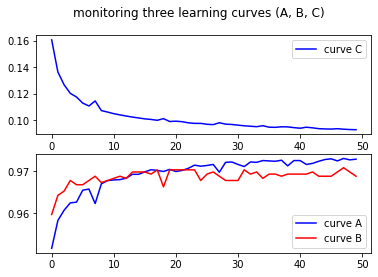

In [135]:
import matplotlib.pyplot as plt

op = Optimizer(lr=0.02, annealing_rate=0.99, batch_size=20, max_epochs=50)

w, A, B, C = logistic_regression_gd(X_train, y_train, X_test, y_test, op)

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, B, C)')
ax[0].plot(C, 'b')
ax[0].legend(['curve C', 'closed-form solution'])

ax[1].plot(A, 'b', B, 'r')
ax[1].legend(['curve A', 'curve B'])

epoch=99: the logistic regression loss is C=0.090 (A=0.973,B=0.968)


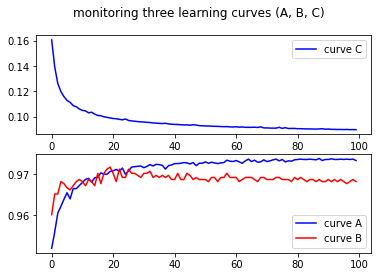

In [136]:
import matplotlib.pyplot as plt

op = Optimizer(lr=0.05, annealing_rate=0.99, batch_size=50, max_epochs=100)

w, A, B, C = logistic_regression_gd(X_train, y_train, X_test, y_test, op)

fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, B, C)')
ax[0].plot(C, 'b')
ax[0].legend(['curve C', 'closed-form solution'])

ax[1].plot(A, 'b', B, 'r')
ax[1].legend(['curve A', 'curve B'])

From the above two settings, we can see that gradient descent can significantly reduce the logistic regression loss throughout the learning process. However, classificaion accuracies on both training and test sets do NOT improve too much after epoch 5. Moreover, the performance gap between A and B is fairly small no matter how we fine-tune the learning hyper-parameters. This suggests that linear models may be too simple to perfectly classify these two digits. 

Comparing with linear regression in Example 2.2, we can see that training accuracy (curve **A**) can be significantly improved in logistic regression while training accuracy (curve **A**) of linear regression constantly stay below curve **B**. This suggests that the loss function of logistic regression is more closely related to the actual zero-one loss in pattern classification than that of linear regression. Moreover, in this task, logistic regression  only slightly outperforms linear regression in the unseen test set (96.9% vs. 95.9%). This also suggests that linear models may be too simple for this binary classification task. 

Finally, let us use the logistic regression implementation from *sciki-learn* to repeat the above binary classification task. 

In [ ]:
# use logistic regression from sklearn

from sklearn.linear_model import LogisticRegression

# create a logistic regression model
log_reg = LogisticRegression(max_iter=10000)

# training: fit the training data
log_reg.fit(X_train,y_train)

# measure the training accuracy 
print(f'training accuracy: {log_reg.score(X_train,y_train)}')

# predit the test data
predict = log_reg.predict(X_test)

print(f'test accuracy: {log_reg.score(X_test,y_test)}')

training accuracy: 0.9778000333834085
test accuracy: 0.9662298387096774


## **Exercises**

### **Problem 3.1:  MCE**

Following Example 3.1, implement minimum classification error (MCE) method in Section 6.3 (page 113) to learn a binary linear classifier to classify two digits ('3' and '8') in the MNIST data set. Compare its performance with that of logistic regress in Example 3.1 and that of linear regression in Example 2.2.

### **Problem 3.2: Log-linear Models**

Use the *softmax* function, i.e. Eq.(6.18) on page 115, to extend the logistic regression model in Example 3.1 from a binary classifier for 2-class tasks to a more general classifier that can deal with multiple-class classification problems. Based on the softmax function, build a 10-class classifier to classify all ten digits in the MNIST data set. 

*Hints:*
1.   Better to encode all 10-class targets using the *one-hot encoding* method, namely, the correct label of each digit is represented as a 10-dimension vector, containing all 0s but a single 1 in the position corresponding to its correct class label. 
2.   Note that this multi-class extension for logistic regression is also called *log-linear models* (see Section 11.4.3).

